In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import BertModel, BertConfig
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from torch.optim.lr_scheduler import ReduceLROnPlateau

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ✅ Load MovieLens-1M Data
def load_data():
    # Load ratings
    ratings = pd.read_csv("ml-1m/ratings.dat", sep="::", engine="python",
                          names=["userId", "movieId", "rating", "timestamp"],
                          encoding="utf-8")
    ratings = ratings.sort_values(by=["userId", "timestamp"])

    # Load movies
    movies = pd.read_csv("ml-1m/movies.dat", sep="::", engine="python",
                         names=["movieId", "title", "genres"],
                         encoding="latin-1")  # ML-1M uses latin-1 encoding

    # ✅ Define available genres
    genre_list = [
        "Action", "Adventure", "Animation", "Children's", "Comedy", "Crime",
        "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror", "Musical",
        "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"
    ]
    genre_dict = {genre: idx + 1 for idx, genre in enumerate(genre_list)}

    # ✅ Convert genres into numerical vectors
    movies["genre_vector"] = movies["genres"].apply(
        lambda x: [genre_dict[g] for g in x.split("|") if g in genre_dict]
    )
    movie_dict = movies.set_index("movieId")["genre_vector"].to_dict()

    # ✅ Create user-movie interaction dictionary
    user_movie_dict = ratings.groupby("userId")["movieId"].apply(list).to_dict()

    return user_movie_dict, movie_dict, genre_dict

# ✅ （Negative Sampling）
def negative_sampling(movie_list, vocab_size, num_neg=5):
    neg_samples = []
    for movie in movie_list:
        neg = []
        while len(neg) < num_neg:
            sampled = np.random.randint(1, vocab_size)
            if sampled not in movie_list:
                neg.append(sampled)
        neg_samples.append(neg)
    return neg_samples

def split_train_test_strict(user_movie_dict, test_user_ratio=0.2, min_interactions=5):
    users = list(user_movie_dict.keys())
    np.random.shuffle(users)
    split_idx = int(len(users) * (1 - test_user_ratio))
    train_users = users[:split_idx]
    test_users = users[split_idx:]

    train_dict = {user: user_movie_dict[user] for user in train_users if len(user_movie_dict[user]) >= min_interactions}
    test_dict = {user: user_movie_dict[user] for user in test_users if len(user_movie_dict[user]) >= min_interactions}

    return train_dict, test_dict

# ✅ Early Stopping Implementation
class EarlyStopping:
    def __init__(self, patience=3, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_loss = float("inf")
        self.counter = 0

    def step(self, val_loss):
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                print("Early stopping triggered.")
                return True
        return False
    
def recall_at_k(top_k_predictions, targets, k):
    """
    Compute Recall@K: 
    - Measures how many of the relevant items (targets) are in the top K recommendations.

    Args:
        top_k_predictions: (batch_size, seq_len, k) - Top K predicted items.
        targets: (batch_size, seq_len) - True target items.
        k: The number of top items considered.
    
    Returns:
        Average Recall@K across all samples.
    """
    hits = (top_k_predictions == targets.unsqueeze(-1)).float()  # Check if target is in top K
    recall = hits.sum(dim=-1).mean().item()  # Compute recall
    return recall

def ndcg_at_k(top_k_predictions, targets, k):
    """
    Compute NDCG@K:
    - Measures ranking quality of recommendations by discounting correct predictions at later ranks.

    Args:
        top_k_predictions: (batch_size, seq_len, k) - Top K predicted items.
        targets: (batch_size, seq_len) - True target items.
        k: The number of top items considered.

    Returns:
        Average NDCG@K across all samples.
    """
    hits = (top_k_predictions == targets.unsqueeze(-1)).float()
    log_positions = 1 / torch.log2(torch.arange(2, k + 2, device=targets.device).float())  # Discount factor
    dcg = (hits * log_positions).sum(dim=-1).mean().item()
    return dcg

epochs = 200
losses_dict = {}

Using device: cpu


In [18]:
#### BERT4Rec Baseline

class MovieDataset_Baseline(Dataset):
    def __init__(self, user_movie_dict, movie_dict, vocab_size, max_len=30, max_genres=5, num_neg=5):
        self.users = list(user_movie_dict.keys())
        self.sequences = [user_movie_dict[user] for user in self.users]
        self.movie_dict = movie_dict
        self.vocab_size = vocab_size
        self.max_len = max_len
        self.max_genres = max_genres
        self.num_neg = num_neg  # Fixed number of negative samples per target

    def __len__(self):
        return len(self.users)

    def __getitem__(self, idx):
        sequence = self.sequences[idx]
        input_ids = sequence[:self.max_len] + [0] * (self.max_len - len(sequence))
        target_ids = input_ids[1:] + [0]

        # ✅ Fixed-shape negative sampling (max_len, num_neg)
        neg_samples = []
        for _ in range(self.max_len):
            neg = []
            while len(neg) < self.num_neg:
                sampled = np.random.randint(1, self.vocab_size)
                if sampled not in sequence:
                    neg.append(sampled)
            neg_samples.append(neg)

        neg_samples = torch.tensor(neg_samples, dtype=torch.long)  # Shape: (max_len, num_neg)

        attention_mask = [1 if id != 0 else 0 for id in input_ids]

        genre_vectors = [self.movie_dict.get(movie, [0]) for movie in input_ids]
        padded_genre_vectors = [g[:self.max_genres] + [0] * (self.max_genres - len(g)) for g in genre_vectors]

        return (
            torch.tensor(input_ids, dtype=torch.long),
            torch.tensor(target_ids, dtype=torch.long),
            neg_samples,  # ✅ Fixed-size tensor (max_len, num_neg)
            torch.tensor(attention_mask, dtype=torch.long),
            torch.tensor(padded_genre_vectors, dtype=torch.long)
        )

# ✅ BERT4Rec
class BERT4Rec(nn.Module):
    def __init__(self, vocab_size, genre_size, hidden_size=256, num_layers=4, num_heads=4, max_len=30, dropout_rate=0.2):
        super(BERT4Rec, self).__init__()
        config = BertConfig(
            vocab_size=vocab_size,
            hidden_size=hidden_size,
            num_attention_heads=num_heads,
            num_hidden_layers=num_layers,
            max_position_embeddings=max_len,
        )
        self.bert = BertModel(config)
        self.output_layer = nn.Linear(hidden_size, vocab_size)

        self.genre_embedding = nn.Embedding(genre_size, hidden_size)
        self.genre_fc = nn.Linear(hidden_size, hidden_size)

        self.layernorm = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, input_ids, attention_mask, genre_ids):
        seq_len = input_ids.shape[1]
        # causal_mask = torch.triu(torch.ones(seq_len, seq_len, dtype=torch.bool, device=input_ids.device), diagonal=1)

        output = self.bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
        genre_emb = self.genre_embedding(genre_ids).mean(dim=2)
        genre_emb = self.genre_fc(genre_emb)

        output = self.layernorm(output + genre_emb)
        output = self.dropout(output)

        return self.output_layer(output)

# ✅ Training with Early Stopping
def train_model(model, dataloader, epochs=10, lr=0.0001):
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    criterion = nn.BCEWithLogitsLoss()
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)
    early_stopping = EarlyStopping(patience=3)

    model.train()
    loss_history = []
        
    for epoch in range(epochs):
        total_loss = 0
        for inputs, targets, neg_samples, attention_mask, genres in dataloader:
            inputs, targets, neg_samples, attention_mask, genres = (
                inputs.to(device), targets.to(device), neg_samples.to(device),
                attention_mask.to(device), genres.to(device)
            )

            optimizer.zero_grad()
            outputs = model(inputs, attention_mask, genres)

            pos_logits = outputs.gather(2, targets.unsqueeze(-1)).squeeze(-1)
            neg_logits = outputs.gather(2, neg_samples).squeeze(-1)

            pos_loss = criterion(pos_logits, torch.ones_like(pos_logits))
            neg_loss = criterion(neg_logits, torch.zeros_like(neg_logits))
            loss = pos_loss + neg_loss.mean()

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            total_loss += loss.item()

            
        avg_loss = total_loss / len(dataloader)
        loss_history.append(avg_loss)
        scheduler.step(avg_loss)
        print(f"Epoch {epoch + 1}, Train Loss: {avg_loss:.4f}")

        if early_stopping.step(total_loss):
            break
            
    return loss_history

# Define Evaluation Function
def evaluate_model_baseline(model, dataloader, k=10):
    model.eval()
    total_loss, total_recall, total_ndcg = 0, 0, 0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for inputs, targets, _, attention_mask, genres in dataloader:
            inputs, targets, attention_mask, genres = inputs.to(device), targets.to(device), attention_mask.to(device), genres.to(device)

            outputs = model(inputs, attention_mask, genres)
            loss = criterion(outputs.view(-1, outputs.shape[-1]), targets.view(-1))
            total_loss += loss.item()

            _, top_k_predictions = torch.topk(outputs, k, dim=-1)
            recall = recall_at_k(top_k_predictions, targets, k)
            ndcg = ndcg_at_k(top_k_predictions, targets, k)

            total_recall += recall
            total_ndcg += ndcg

    print(f"Test Loss: {total_loss / len(dataloader):.4f}, Recall@{k}: {total_recall / len(dataloader):.4f}, NDCG@{k}: {total_ndcg / len(dataloader):.4f}")

user_movie_dict, movie_dict, genre_dict = load_data()
print(f"Loaded {len(user_movie_dict)} users' movie interaction sequences")
train_dict, test_dict = split_train_test_strict(user_movie_dict)
print(f"Train users: {len(train_dict)}, Test users: {len(test_dict)}")

vocab_size = max(max(seq) for seq in user_movie_dict.values()) + 1
train_dataset = MovieDataset_Baseline(train_dict, movie_dict, vocab_size)
train_dataloader = DataLoader(train_dataset, batch_size=32, num_workers=0, shuffle=True)
test_dataset = MovieDataset_Baseline(test_dict, movie_dict, vocab_size)
test_dataloader = DataLoader(test_dataset, batch_size=32, num_workers=0, shuffle=False)
            
model_baseline = BERT4Rec(vocab_size, len(genre_dict) + 1, dropout_rate=0.4).to(device)
loss_history_baseline = train_model(model_baseline, train_dataloader, epochs=epochs, lr=0.0001)
# Evaluate Model
evaluate_model_baseline(model_baseline, test_dataloader, k=10)

Loaded 6040 users' movie interaction sequences
Train users: 4832, Test users: 1208
Epoch 1, Train Loss: 1.0829
Epoch 2, Train Loss: 0.8475
Epoch 3, Train Loss: 0.8103
Epoch 4, Train Loss: 0.7828
Epoch 5, Train Loss: 0.7473
Epoch 6, Train Loss: 0.6993
Epoch 7, Train Loss: 0.6543
Epoch 8, Train Loss: 0.6029
Epoch 9, Train Loss: 0.5485
Epoch 10, Train Loss: 0.4827
Epoch 11, Train Loss: 0.4010
Epoch 12, Train Loss: 0.3439
Epoch 13, Train Loss: 0.3007
Epoch 14, Train Loss: 0.2667
Epoch 15, Train Loss: 0.2386
Epoch 16, Train Loss: 0.2134
Epoch 17, Train Loss: 0.1932
Epoch 18, Train Loss: 0.1756
Epoch 19, Train Loss: 0.1609
Epoch 20, Train Loss: 0.1475
Epoch 21, Train Loss: 0.1365
Epoch 22, Train Loss: 0.1262
Epoch 23, Train Loss: 0.1167
Epoch 24, Train Loss: 0.1083
Epoch 25, Train Loss: 0.1014
Epoch 26, Train Loss: 0.0954
Epoch 27, Train Loss: 0.0891
Epoch 28, Train Loss: 0.0839
Epoch 29, Train Loss: 0.0794
Epoch 30, Train Loss: 0.0754
Epoch 31, Train Loss: 0.0715
Epoch 32, Train Loss: 0.068

In [19]:
### BERT4Rect-UP

# ✅ Load MovieLens-1M Data (Users, Ratings, Movies)
def load_ratings(filepath="ml-1m/ratings.dat"):
    df = pd.read_csv(filepath, sep="::", engine="python",
                     names=["userId", "movieId", "rating", "timestamp"],
                     encoding="utf-8")
    df = df.sort_values(by=["userId", "timestamp"])
    user_movie_dict = df.groupby("userId")["movieId"].apply(list).to_dict()
    return user_movie_dict, df

def load_users(filepath="ml-1m/users.dat"):
    user_df = pd.read_csv(filepath, sep="::", engine="python",
                           names=["userId", "gender", "age", "occupation", "zip-code"],
                           encoding="utf-8")

    gender_map = {"M": 0, "F": 1}
    user_df["gender"] = user_df["gender"].map(gender_map)

    age_groups = {1: 0, 18: 1, 25: 2, 35: 3, 45: 4, 50: 5, 56: 6}
    user_df["age"] = user_df["age"].map(age_groups)

    users_dict = user_df.set_index("userId")[["gender", "age", "occupation"]].to_dict("index")
    return users_dict

def load_movies(filepath="ml-1m/movies.dat"):
    movies = pd.read_csv(filepath, sep="::", engine="python",
                         names=["movieId", "title", "genres"], encoding="latin-1")

    genre_list = [
        "Action", "Adventure", "Animation", "Children's", "Comedy", "Crime",
        "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror", "Musical",
        "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"
    ]
    genre_dict = {genre: i + 1 for i, genre in enumerate(genre_list)}

    movies["genre_vector"] = movies["genres"].apply(lambda x: [genre_dict[g] for g in x.split("|") if g in genre_dict])
    movie_dict = movies.set_index("movieId")["genre_vector"].to_dict()

    return movie_dict, genre_dict

def negative_sampling(movie_list, vocab_size, num_neg=2, max_len=30):
    neg_samples = []
    for _ in range(max_len):
        neg = []
        while len(neg) < num_neg:
            sampled = np.random.randint(1, vocab_size)
            if sampled not in movie_list:
                neg.append(sampled)
        neg_samples.append(neg)
    return neg_samples  # Shape: (max_len, num_neg)

class MovieDataset_UP(Dataset):
    def __init__(self, user_movie_dict, users_dict, movie_dict, vocab_size, max_len=30, num_neg=2, max_genres=5):
        self.users = list(user_movie_dict.keys())
        self.sequences = [user_movie_dict[user] for user in self.users]
        self.user_profiles = [users_dict[user] for user in self.users]
        self.movie_dict = movie_dict
        self.vocab_size = vocab_size
        self.max_len = max_len
        self.num_neg = num_neg
        self.max_genres = max_genres

    def __len__(self):
        return len(self.users)

    def __getitem__(self, idx):
        sequence = self.sequences[idx]
        user_profile = self.user_profiles[idx]

        gender, age, occupation = (
            user_profile["gender"], user_profile["age"], user_profile["occupation"]
        )

        input_ids = sequence[:self.max_len] + [0] * (self.max_len - len(sequence))
        target_ids = input_ids[1:] + [0]
        attention_mask = [1 if id != 0 else 0 for id in input_ids]

        # ✅ 外部调用negative_sampling
        neg_samples = negative_sampling(sequence, self.vocab_size, self.num_neg, self.max_len)
        neg_samples = torch.tensor(neg_samples, dtype=torch.long)

        genre_vectors = [self.movie_dict.get(movie, [0]) for movie in input_ids]
        padded_genre_vectors = [g[:self.max_genres] + [0] * (self.max_genres - len(g)) for g in genre_vectors]
        genre_tensor = torch.tensor(padded_genre_vectors, dtype=torch.long)

        return (
            torch.tensor(input_ids, dtype=torch.long),
            torch.tensor(target_ids, dtype=torch.long),
            neg_samples,
            torch.tensor(attention_mask, dtype=torch.long),
            torch.tensor(gender, dtype=torch.long),
            torch.tensor(age, dtype=torch.long),
            torch.tensor(occupation, dtype=torch.long),
            genre_tensor
        )

class BERT4Rec_UP(nn.Module):
    def __init__(self, vocab_size, num_genres, hidden_size=256, num_layers=4, num_heads=4, max_len=30, dropout_rate=0.2):
        super(BERT4Rec_UP, self).__init__()
        config = BertConfig(
            vocab_size=vocab_size, hidden_size=hidden_size, num_attention_heads=num_heads,
            num_hidden_layers=num_layers, max_position_embeddings=max_len
        )
        self.bert = BertModel(config)
        split_size = hidden_size // 3  # Adjusted due to removing activity embedding
        self.gender_embedding = nn.Embedding(2, split_size)
        self.age_embedding = nn.Embedding(7, split_size)
        self.occupation_embedding = nn.Embedding(21, split_size)
        self.genre_embedding = nn.Embedding(num_genres, hidden_size)
        self.genre_fc = nn.Linear(hidden_size, hidden_size)
        self.user_fc = nn.Linear(split_size * 3, hidden_size)
        self.user_dropout = nn.Dropout(dropout_rate)
        self.final_dropout = nn.Dropout(dropout_rate)
        self.output_layer = nn.Linear(hidden_size, vocab_size)
    
    def forward(self, input_ids, attention_mask, gender, age, occupation, genre_ids):
        batch_size, seq_len = input_ids.shape
        transformer_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        ).last_hidden_state
        genre_emb = self.genre_embedding(genre_ids).mean(dim=2)
        genre_emb = self.genre_fc(genre_emb)
        user_emb = self.user_fc(torch.cat([
            self.gender_embedding(gender).unsqueeze(1).expand(-1, seq_len, -1),
            self.age_embedding(age).unsqueeze(1).expand(-1, seq_len, -1),
            self.occupation_embedding(occupation).unsqueeze(1).expand(-1, seq_len, -1)
        ], dim=-1))
        user_emb = self.user_dropout(user_emb)
        output = transformer_output + user_emb + genre_emb
        return self.output_layer(self.final_dropout(output))

# ✅ Updated Training Function
def train_model_up(model, dataloader, epochs=10, lr=0.0001):
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    criterion_ce = nn.CrossEntropyLoss(ignore_index=0)  # Used for positive samples
    criterion_bce = nn.BCEWithLogitsLoss()  # Used for negative sampling
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)
    early_stopping = EarlyStopping(patience=3)

    model.train()
    loss_history = [] 

    for epoch in range(epochs):
        total_loss = 0
        for inputs, targets, neg_samples, attention_mask, gender, age, occupation, genre_ids in dataloader:
            inputs, targets, neg_samples, attention_mask, gender, age, occupation, genre_ids = (
                inputs.to(device), targets.to(device), neg_samples.to(device),
                attention_mask.to(device), gender.to(device), age.to(device),
                occupation.to(device),
                genre_ids.to(device)
            )

            optimizer.zero_grad()
            outputs = model(inputs, attention_mask, gender, age, occupation, genre_ids)  
            # ✅ outputs.shape = [batch_size, seq_len, vocab_size]

            # ✅ Compute Positive Sample Loss (CrossEntropy)
            pos_loss = criterion_ce(outputs.view(-1, outputs.shape[-1]), targets.view(-1))  # Targets must be long integers

            # ✅ Compute Negative Sample Loss (Binary Classification)
            neg_logits = outputs.gather(2, neg_samples).squeeze(-1)  # Extract negative logits
            neg_labels = torch.zeros_like(neg_logits)  # Label negative samples as "0"
            neg_loss = criterion_bce(neg_logits, neg_labels.float())  # BCE expects float targets

            # ✅ Compute Final Loss
            loss = pos_loss + neg_loss.mean()

            # ✅ Backpropagation
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            total_loss += loss.item()

        # ✅ Learning Rate Scheduling
        avg_loss = total_loss / len(dataloader)
        loss_history.append(avg_loss)  # 记录 loss
        scheduler.step(avg_loss)
        print(f"Epoch {epoch + 1}, Train Loss: {avg_loss:.4f}")

        # ✅ Early Stopping
        if early_stopping.step(total_loss):
            break
    return loss_history  

def evaluate_model_up(model, dataloader, k=10):
    """
    Evaluate the BERT4Rec model on test data.

    Args:
        model: The trained BERT4Rec model.
        dataloader: Test DataLoader.
        k: Top-K predictions to consider for Recall and NDCG.

    Returns:
        None
    """
    model.eval()
    total_loss, total_recall, total_ndcg = 0, 0, 0
    criterion = nn.CrossEntropyLoss(ignore_index=0)

    with torch.no_grad():
        for batch in dataloader:
            # Unpack batch
            inputs, targets, neg_samples, attention_mask, gender, age, occupation, genres = batch

            # Move to device
            inputs, targets, attention_mask = inputs.to(device), targets.to(device), attention_mask.to(device)
            gender, age, occupation, genres = (
                gender.to(device), age.to(device), occupation.to(device),
                genres.to(device)
            )

            # Forward pass
            outputs = model(inputs, attention_mask, gender, age, occupation, genres)
            loss = criterion(outputs.view(-1, outputs.shape[-1]), targets.view(-1))
            total_loss += loss.item()

            # Compute Recall@K & NDCG@K
            _, top_k_predictions = torch.topk(outputs, k, dim=-1)  # Get top K movie predictions
            recall = recall_at_k(top_k_predictions, targets, k)
            ndcg = ndcg_at_k(top_k_predictions, targets, k)

            total_recall += recall
            total_ndcg += ndcg

    avg_loss = total_loss / len(dataloader)
    avg_recall = total_recall / len(dataloader)
    avg_ndcg = total_ndcg / len(dataloader)

    print(f"Test Loss: {avg_loss:.4f}, Recall@{k}: {avg_recall:.4f}, NDCG@{k}: {avg_ndcg:.4f}")

# ✅ Load datasets
user_movie_dict, ratings_df = load_ratings()
users_dict = load_users()
movie_dict, genre_dict = load_movies()
print(f"Loaded {len(user_movie_dict)} users' movie interaction sequences.")
train_dict, test_dict = split_train_test_strict(user_movie_dict)
print(f"Train users: {len(train_dict)}, Test users: {len(test_dict)}")
vocab_size = max(max(seq) for seq in user_movie_dict.values()) + 1

# ✅ Update DataLoaders with `genre_ids`
train_dataset = MovieDataset_UP(train_dict, users_dict, movie_dict, vocab_size)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = MovieDataset_UP(test_dict, users_dict, movie_dict, vocab_size)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)
vocab_size = max(max(seq) for seq in user_movie_dict.values()) + 1
print(f"Model initialized with vocab size {vocab_size}")

model_up = BERT4Rec_UP(vocab_size, len(genre_dict) + 1, dropout_rate=0.3).to(device)
# ✅ Train the Model
loss_history_up = train_model_up(model_up, train_dataloader, epochs=epochs, lr=0.0001)
evaluate_model_up(model_up, test_dataloader, k=10)

Loaded 6040 users' movie interaction sequences.
Train users: 4832, Test users: 1208
Model initialized with vocab size 3953
Epoch 1, Train Loss: 7.9873
Epoch 2, Train Loss: 7.2153
Epoch 3, Train Loss: 6.7783
Epoch 4, Train Loss: 6.2292
Epoch 5, Train Loss: 4.9588
Epoch 6, Train Loss: 3.2603
Epoch 7, Train Loss: 2.1169
Epoch 8, Train Loss: 1.4054
Epoch 9, Train Loss: 0.9544
Epoch 10, Train Loss: 0.6689
Epoch 11, Train Loss: 0.4833
Epoch 12, Train Loss: 0.3644
Epoch 13, Train Loss: 0.2831
Epoch 14, Train Loss: 0.2281
Epoch 15, Train Loss: 0.1855
Epoch 16, Train Loss: 0.1543
Epoch 17, Train Loss: 0.1303
Epoch 18, Train Loss: 0.1120
Epoch 19, Train Loss: 0.0979
Epoch 20, Train Loss: 0.0851
Epoch 21, Train Loss: 0.0750
Epoch 22, Train Loss: 0.0673
Epoch 23, Train Loss: 0.0611
Epoch 24, Train Loss: 0.0551
Epoch 25, Train Loss: 0.0504
Epoch 26, Train Loss: 0.0466
Epoch 27, Train Loss: 0.0434
Epoch 28, Train Loss: 0.0405
Epoch 29, Train Loss: 0.0382
Epoch 30, Train Loss: 0.0359
Epoch 31, Train 

In [20]:
#### BERT4Rec_UPC

# ✅ Load MovieLens-1M Data (Users, Ratings, Movies)
def load_ratings(filepath="ml-1m/ratings.dat"):
    df = pd.read_csv(filepath, sep="::", engine="python",
                     names=["userId", "movieId", "rating", "timestamp"],
                     encoding="utf-8")
    df = df.sort_values(by=["userId", "timestamp"])
    user_movie_dict = df.groupby("userId")["movieId"].apply(list).to_dict()
    return user_movie_dict, df

def load_users(filepath="ml-1m/users.dat"):
    user_df = pd.read_csv(filepath, sep="::", engine="python",
                           names=["userId", "gender", "age", "occupation", "zip-code"],
                           encoding="utf-8")

    gender_map = {"M": 0, "F": 1}
    user_df["gender"] = user_df["gender"].map(gender_map)

    age_groups = {1: 0, 18: 1, 25: 2, 35: 3, 45: 4, 50: 5, 56: 6}
    user_df["age"] = user_df["age"].map(age_groups)

    users_dict = user_df.set_index("userId")[["gender", "age", "occupation"]].to_dict("index")
    return users_dict

def load_movies(filepath="ml-1m/movies.dat"):
    movies = pd.read_csv(filepath, sep="::", engine="python",
                         names=["movieId", "title", "genres"], encoding="latin-1")

    genre_list = [
        "Action", "Adventure", "Animation", "Children's", "Comedy", "Crime",
        "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror", "Musical",
        "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"
    ]
    genre_dict = {genre: i + 1 for i, genre in enumerate(genre_list)}

    movies["genre_vector"] = movies["genres"].apply(lambda x: [genre_dict[g] for g in x.split("|") if g in genre_dict])
    movie_dict = movies.set_index("movieId")["genre_vector"].to_dict()

    return movie_dict, genre_dict

# ✅ Negative Sampling
def negative_sampling(movie_list, vocab_size, num_neg=2, max_len=30):
    neg_samples = []
    for _ in range(max_len):
        neg = []
        while len(neg) < num_neg:
            sampled = np.random.randint(1, vocab_size)
            if sampled not in movie_list:
                neg.append(sampled)
        neg_samples.append(neg)
    return neg_samples  # Shape: (max_len, num_neg)
    
class MovieDataset_UPC(Dataset):
    def __init__(self, user_movie_dict, users_dict, movie_dict, vocab_size, max_len=30, num_neg=2, max_genres=5):
        self.users = list(user_movie_dict.keys())
        self.sequences = [user_movie_dict[user] for user in self.users]
        self.user_profiles = [users_dict[user] for user in self.users]
        self.movie_dict = movie_dict
        self.vocab_size = vocab_size
        self.max_len = max_len
        self.num_neg = num_neg
        self.max_genres = max_genres

    def __len__(self):
        return len(self.users)

    def __getitem__(self, idx):
        sequence = self.sequences[idx]
        user_profile = self.user_profiles[idx]

        gender, age, occupation, cluster = (
            user_profile["gender"], user_profile["age"], user_profile["occupation"],
            user_profile["cluster"]
        )

        input_ids = sequence[:self.max_len] + [0] * (self.max_len - len(sequence))
        target_ids = input_ids[1:] + [0]
        attention_mask = [1 if id != 0 else 0 for id in input_ids]

        # ✅ 外部调用negative_sampling
        neg_samples = negative_sampling(sequence, self.vocab_size, self.num_neg, self.max_len)
        neg_samples = torch.tensor(neg_samples, dtype=torch.long)

        genre_vectors = [self.movie_dict.get(movie, [0]) for movie in input_ids]
        padded_genre_vectors = [g[:self.max_genres] + [0] * (self.max_genres - len(g)) for g in genre_vectors]
        genre_tensor = torch.tensor(padded_genre_vectors, dtype=torch.long)

        return (
            torch.tensor(input_ids, dtype=torch.long),
            torch.tensor(target_ids, dtype=torch.long),
            neg_samples,
            torch.tensor(attention_mask, dtype=torch.long),
            torch.tensor(gender, dtype=torch.long),
            torch.tensor(age, dtype=torch.long),
            torch.tensor(occupation, dtype=torch.long),
            torch.tensor(cluster, dtype=torch.long),
            genre_tensor
        )

class BERT4Rec_UPC(nn.Module):
    def __init__(self, vocab_size, num_clusters, num_genres, hidden_size=256, num_layers=4, num_heads=4, max_len=30, dropout_rate=0.2):
        super(BERT4Rec_UPC, self).__init__()
        config = BertConfig(
            vocab_size=vocab_size, hidden_size=hidden_size, num_attention_heads=num_heads,
            num_hidden_layers=num_layers, max_position_embeddings=max_len
        )
        self.bert = BertModel(config)
        split_size = hidden_size // 4  # Adjusted due to removing activity embedding
        self.gender_embedding = nn.Embedding(2, split_size)
        self.age_embedding = nn.Embedding(7, split_size)
        self.occupation_embedding = nn.Embedding(21, split_size)
        self.cluster_embedding = nn.Embedding(num_clusters, split_size)
        self.genre_embedding = nn.Embedding(num_genres, hidden_size)
        self.genre_fc = nn.Linear(hidden_size, hidden_size)
        self.user_fc = nn.Linear(split_size * 4, hidden_size)
        self.user_dropout = nn.Dropout(dropout_rate)
        self.final_dropout = nn.Dropout(dropout_rate)
        self.output_layer = nn.Linear(hidden_size, vocab_size)
    
    def forward(self, input_ids, attention_mask, gender, age, occupation, cluster, genre_ids):
        batch_size, seq_len = input_ids.shape
        causal_mask = torch.triu(torch.ones((seq_len, seq_len), dtype=torch.bool, device=input_ids.device), diagonal=1)
        transformer_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            encoder_attention_mask=~causal_mask
        ).last_hidden_state
        genre_emb = self.genre_embedding(genre_ids).mean(dim=2)
        genre_emb = self.genre_fc(genre_emb)
        user_emb = self.user_fc(torch.cat([
            self.gender_embedding(gender).unsqueeze(1).expand(-1, seq_len, -1),
            self.age_embedding(age).unsqueeze(1).expand(-1, seq_len, -1),
            self.occupation_embedding(occupation).unsqueeze(1).expand(-1, seq_len, -1),
            self.cluster_embedding(cluster).unsqueeze(1).expand(-1, seq_len, -1)
        ], dim=-1))
        user_emb = self.user_dropout(user_emb)
        output = transformer_output + user_emb + genre_emb
        return self.output_layer(self.final_dropout(output))

# ✅ Updated Training Function
def train_model_upc(model, dataloader, epochs=10, lr=0.0001):
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    criterion_ce = nn.CrossEntropyLoss(ignore_index=0)  # Used for positive samples
    criterion_bce = nn.BCEWithLogitsLoss()  # Used for negative sampling
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)
    early_stopping = EarlyStopping(patience=3)

    model.train()
    loss_history = []

    for epoch in range(epochs):
        total_loss = 0
        for inputs, targets, neg_samples, attention_mask, gender, age, occupation, cluster, genre_ids in dataloader:
            inputs, targets, neg_samples, attention_mask, gender, age, occupation, cluster, genre_ids = (
                inputs.to(device), targets.to(device), neg_samples.to(device),
                attention_mask.to(device), gender.to(device), age.to(device),
                occupation.to(device), cluster.to(device),
                genre_ids.to(device)
            )

            optimizer.zero_grad()
            outputs = model(inputs, attention_mask, gender, age, occupation, cluster, genre_ids)  
            # ✅ outputs.shape = [batch_size, seq_len, vocab_size]

            # ✅ Compute Positive Sample Loss (CrossEntropy)
            pos_loss = criterion_ce(outputs.view(-1, outputs.shape[-1]), targets.view(-1))  # Targets must be long integers

            # ✅ Compute Negative Sample Loss (Binary Classification)
            neg_logits = outputs.gather(2, neg_samples).squeeze(-1)  # Extract negative logits
            neg_labels = torch.zeros_like(neg_logits)  # Label negative samples as "0"
            neg_loss = criterion_bce(neg_logits, neg_labels.float())  # BCE expects float targets

            # ✅ Compute Final Loss
            loss = pos_loss + neg_loss.mean()

            # ✅ Backpropagation
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            total_loss += loss.item()

        # ✅ Learning Rate Scheduling
        avg_loss = total_loss / len(dataloader)
        loss_history.append(avg_loss) 
        scheduler.step(avg_loss)
        print(f"Epoch {epoch + 1}, Train Loss: {avg_loss:.4f}")

        # ✅ Early Stopping
        if early_stopping.step(total_loss):
            break
    return loss_history  # 返回 loss 记录

def evaluate_model_upc(model, dataloader, k=10):
    """
    Evaluate the BERT4Rec model on test data.

    Args:
        model: The trained BERT4Rec model.
        dataloader: Test DataLoader.
        k: Top-K predictions to consider for Recall and NDCG.

    Returns:
        None
    """
    model.eval()
    total_loss, total_recall, total_ndcg = 0, 0, 0
    criterion = nn.CrossEntropyLoss(ignore_index=0)

    with torch.no_grad():
        for batch in dataloader:
            # Unpack batch
            inputs, targets, neg_samples, attention_mask, gender, age, occupation, cluster, genres = batch

            # Move to device
            inputs, targets, attention_mask = inputs.to(device), targets.to(device), attention_mask.to(device)
            gender, age, occupation, cluster, genres = (
                gender.to(device), age.to(device), occupation.to(device), cluster.to(device),
                genres.to(device)
            )

            # Forward pass
            outputs = model(inputs, attention_mask, gender, age, occupation, cluster, genres)
            loss = criterion(outputs.view(-1, outputs.shape[-1]), targets.view(-1))
            total_loss += loss.item()

            # Compute Recall@K & NDCG@K
            _, top_k_predictions = torch.topk(outputs, k, dim=-1)  # Get top K movie predictions
            recall = recall_at_k(top_k_predictions, targets, k)
            ndcg = ndcg_at_k(top_k_predictions, targets, k)

            total_recall += recall
            total_ndcg += ndcg

    avg_loss = total_loss / len(dataloader)
    avg_recall = total_recall / len(dataloader)
    avg_ndcg = total_ndcg / len(dataloader)

    print(f"Test Loss: {avg_loss:.4f}, Recall@{k}: {avg_recall:.4f}, NDCG@{k}: {avg_ndcg:.4f}")

# ✅ Load datasets
user_movie_dict, ratings_df = load_ratings()
users_dict = load_users()
movie_dict, genre_dict = load_movies()

print(f"Loaded {len(user_movie_dict)} users' movie interaction sequences.")
train_dict, test_dict = split_train_test_strict(user_movie_dict)
print(f"Train users: {len(train_dict)}, Test users: {len(test_dict)}")
# ✅ Define vocab_size
vocab_size = max(max(seq) for seq in user_movie_dict.values()) + 1

# ✅ User Clustering using K-Means
from sklearn.cluster import KMeans
num_clusters = 5
user_features = np.array([[users_dict[u]["gender"], users_dict[u]["age"], users_dict[u]["occupation"]] for u in users_dict.keys()])
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
kmeans_clusters = kmeans.fit_predict(user_features)

for idx, user_id in enumerate(users_dict.keys()):
    users_dict[user_id]["cluster"] = kmeans_clusters[idx]
    
# ✅ Update DataLoaders with `genre_ids`
train_dataset = MovieDataset_UPC(train_dict, users_dict, movie_dict, vocab_size)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = MovieDataset_UPC(test_dict, users_dict, movie_dict, vocab_size)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

vocab_size = max(max(seq) for seq in user_movie_dict.values()) + 1
model_upc = BERT4Rec_UPC(vocab_size, num_clusters, len(genre_dict) + 1, dropout_rate=0.3).to(device)
print(f"Model initialized with vocab size {vocab_size} and {num_clusters} user clusters.")

# ✅ Train the Model
loss_history_upc = train_model_upc(model_upc, train_dataloader, epochs=epochs, lr=0.0001)
evaluate_model_upc(model_upc, test_dataloader, k=10)

Loaded 6040 users' movie interaction sequences.
Train users: 4832, Test users: 1208
Model initialized with vocab size 3953 and 5 user clusters.
Epoch 1, Train Loss: 8.0120
Epoch 2, Train Loss: 7.1957
Epoch 3, Train Loss: 6.7454
Epoch 4, Train Loss: 6.2213
Epoch 5, Train Loss: 5.0302
Epoch 6, Train Loss: 3.3039
Epoch 7, Train Loss: 2.1272
Epoch 8, Train Loss: 1.3991
Epoch 9, Train Loss: 0.9467
Epoch 10, Train Loss: 0.6573
Epoch 11, Train Loss: 0.4768
Epoch 12, Train Loss: 0.3612
Epoch 13, Train Loss: 0.2810
Epoch 14, Train Loss: 0.2251
Epoch 15, Train Loss: 0.1838
Epoch 16, Train Loss: 0.1537
Epoch 17, Train Loss: 0.1300
Epoch 18, Train Loss: 0.1102
Epoch 19, Train Loss: 0.0964
Epoch 20, Train Loss: 0.0850
Epoch 21, Train Loss: 0.0751
Epoch 22, Train Loss: 0.0671
Epoch 23, Train Loss: 0.0603
Epoch 24, Train Loss: 0.0549
Epoch 25, Train Loss: 0.0506
Epoch 26, Train Loss: 0.0465
Epoch 27, Train Loss: 0.0432
Epoch 28, Train Loss: 0.0401
Epoch 29, Train Loss: 0.0378
Epoch 30, Train Loss: 0.

In [21]:
### BERT4REC_UPCA

# ✅ Load MovieLens-1M Data (Users, Ratings, Movies)
def load_ratings(filepath="ml-1m/ratings.dat"):
    df = pd.read_csv(filepath, sep="::", engine="python",
                     names=["userId", "movieId", "rating", "timestamp"],
                     encoding="utf-8")
    df = df.sort_values(by=["userId", "timestamp"])
    user_movie_dict = df.groupby("userId")["movieId"].apply(list).to_dict()
    return user_movie_dict, df

def load_users(filepath="ml-1m/users.dat"):
    user_df = pd.read_csv(filepath, sep="::", engine="python",
                           names=["userId", "gender", "age", "occupation", "zip-code"],
                           encoding="utf-8")

    gender_map = {"M": 0, "F": 1}
    user_df["gender"] = user_df["gender"].map(gender_map)

    age_groups = {1: 0, 18: 1, 25: 2, 35: 3, 45: 4, 50: 5, 56: 6}
    user_df["age"] = user_df["age"].map(age_groups)

    users_dict = user_df.set_index("userId")[["gender", "age", "occupation"]].to_dict("index")
    return users_dict

def load_movies(filepath="ml-1m/movies.dat"):
    movies = pd.read_csv(filepath, sep="::", engine="python",
                         names=["movieId", "title", "genres"], encoding="latin-1")

    genre_list = [
        "Action", "Adventure", "Animation", "Children's", "Comedy", "Crime",
        "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror", "Musical",
        "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"
    ]
    genre_dict = {genre: i + 1 for i, genre in enumerate(genre_list)}

    movies["genre_vector"] = movies["genres"].apply(lambda x: [genre_dict[g] for g in x.split("|") if g in genre_dict])
    movie_dict = movies.set_index("movieId")["genre_vector"].to_dict()

    return movie_dict, genre_dict

# ✅ Negative Sampling
def negative_sampling(movie_list, vocab_size, num_neg=2, max_len=30):
    neg_samples = []
    for _ in range(max_len):
        neg = []
        while len(neg) < num_neg:
            sampled = np.random.randint(1, vocab_size)
            if sampled not in movie_list:
                neg.append(sampled)
        neg_samples.append(neg)
    return neg_samples  # Shape: (max_len, num_neg)

class MovieDataset_UPCA(Dataset):
    def __init__(self, user_movie_dict, users_dict, movie_dict, vocab_size, max_len=30, num_neg=2, max_genres=5):
        self.users = list(user_movie_dict.keys())
        self.sequences = [user_movie_dict[user] for user in self.users]
        self.user_profiles = [users_dict[user] for user in self.users]
        self.movie_dict = movie_dict
        self.vocab_size = vocab_size
        self.max_len = max_len
        self.num_neg = num_neg
        self.max_genres = max_genres

    def __len__(self):
        return len(self.users)

    def __getitem__(self, idx):
        sequence = self.sequences[idx]
        user_profile = self.user_profiles[idx]

        gender, age, occupation, cluster, activity_level = (
            user_profile["gender"], user_profile["age"], user_profile["occupation"],
            user_profile["cluster"], user_profile["activity_level"]
        )

        input_ids = sequence[:self.max_len] + [0] * (self.max_len - len(sequence))
        target_ids = input_ids[1:] + [0]
        attention_mask = [1 if id != 0 else 0 for id in input_ids]

        # ✅ 外部调用negative_sampling
        neg_samples = negative_sampling(sequence, self.vocab_size, self.num_neg, self.max_len)
        neg_samples = torch.tensor(neg_samples, dtype=torch.long)

        genre_vectors = [self.movie_dict.get(movie, [0]) for movie in input_ids]
        padded_genre_vectors = [g[:self.max_genres] + [0] * (self.max_genres - len(g)) for g in genre_vectors]
        genre_tensor = torch.tensor(padded_genre_vectors, dtype=torch.long)

        return (
            torch.tensor(input_ids, dtype=torch.long),
            torch.tensor(target_ids, dtype=torch.long),
            neg_samples,
            torch.tensor(attention_mask, dtype=torch.long),
            torch.tensor(gender, dtype=torch.long),
            torch.tensor(age, dtype=torch.long),
            torch.tensor(occupation, dtype=torch.long),
            torch.tensor(cluster, dtype=torch.long),
            torch.tensor(activity_level, dtype=torch.long),
            genre_tensor
        )

# ✅ Corrected BERT4Rec Model with User & Genre Embeddings
class BERT4Rec_UPCA(nn.Module):
    def __init__(self, vocab_size, num_clusters, num_genres, hidden_size=256, num_layers=4, num_heads=4, max_len=30, dropout_rate=0.2):
        super(BERT4Rec_UPCA, self).__init__()

        # ✅ Transformer Configuration
        config = BertConfig(
            vocab_size=vocab_size,
            hidden_size=hidden_size,
            num_attention_heads=num_heads,
            num_hidden_layers=num_layers,
            max_position_embeddings=max_len,
        )

        # ✅ Transformer Encoder
        self.bert = BertModel(config)
        
        # ✅ User Feature Embeddings
        split_size = hidden_size // 5  
        self.gender_embedding = nn.Embedding(2, split_size)
        self.age_embedding = nn.Embedding(7, split_size)
        self.occupation_embedding = nn.Embedding(21, split_size)
        self.cluster_embedding = nn.Embedding(num_clusters, split_size)
        self.activity_embedding = nn.Embedding(2, split_size)

        # ✅ Movie Genre Embeddings
        self.genre_embedding = nn.Embedding(num_genres, hidden_size)
        self.genre_fc = nn.Linear(hidden_size, hidden_size)

        # ✅ Fully Connected Layer for User Features
        self.user_fc = nn.Linear(split_size * 5, hidden_size)

        # ✅ Dropout Regularization
        self.user_dropout = nn.Dropout(dropout_rate)
        self.final_dropout = nn.Dropout(dropout_rate)

        # ✅ Output Layer (Predict Next Movie)
        self.output_layer = nn.Linear(hidden_size, vocab_size)


    def forward(self, input_ids, attention_mask, gender, age, occupation, cluster, activity_level, genre_ids):
        batch_size, seq_len = input_ids.shape

        # ✅ Causal Mask (Prevents Information Leakage)
        causal_mask = torch.triu(torch.ones(seq_len, seq_len, dtype=torch.bool, device=input_ids.device), diagonal=1)

        # ✅ Transformer Output
        transformer_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            encoder_attention_mask=~causal_mask
        ).last_hidden_state

        # ✅ Movie Genre Embedding
        genre_emb = self.genre_embedding(genre_ids).mean(dim=2)  
        genre_emb = self.genre_fc(genre_emb)

        # ✅ User Profile Embeddings (Expand to Sequence Length)
        user_emb = torch.cat([
            self.gender_embedding(gender).unsqueeze(1).expand(-1, seq_len, -1),
            self.age_embedding(age).unsqueeze(1).expand(-1, seq_len, -1),
            self.occupation_embedding(occupation).unsqueeze(1).expand(-1, seq_len, -1),
            self.cluster_embedding(cluster).unsqueeze(1).expand(-1, seq_len, -1),
            self.activity_embedding(activity_level).unsqueeze(1).expand(-1, seq_len, -1)
        ], dim=-1)

        # ✅ Fully Connected User Features
        user_emb = self.user_fc(user_emb)
        user_emb = self.user_dropout(user_emb)  

        # ✅ Inject User & Genre Information into Transformer Output
        output = transformer_output + user_emb + genre_emb  
        output = self.final_dropout(output)

        # ✅ Predict Next Movie
        return self.output_layer(output)

# ✅ Updated Training Function
def train_model_upca(model, dataloader, epochs=10, lr=0.0001):
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    criterion_ce = nn.CrossEntropyLoss(ignore_index=0)  # Used for positive samples
    criterion_bce = nn.BCEWithLogitsLoss()  # Used for negative sampling
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)
    early_stopping = EarlyStopping(patience=3)

    model.train()
    loss_history = [] 

    for epoch in range(epochs):
        total_loss = 0
        for inputs, targets, neg_samples, attention_mask, gender, age, occupation, cluster, activity_level, genre_ids in dataloader:
            inputs, targets, neg_samples, attention_mask, gender, age, occupation, cluster, activity_level, genre_ids = (
                inputs.to(device), targets.to(device), neg_samples.to(device),
                attention_mask.to(device), gender.to(device), age.to(device),
                occupation.to(device), cluster.to(device), activity_level.to(device),
                genre_ids.to(device)
            )

            optimizer.zero_grad()
            outputs = model(inputs, attention_mask, gender, age, occupation, cluster, activity_level, genre_ids)  
            # ✅ outputs.shape = [batch_size, seq_len, vocab_size]

            # ✅ Compute Positive Sample Loss (CrossEntropy)
            pos_loss = criterion_ce(outputs.view(-1, outputs.shape[-1]), targets.view(-1))  # Targets must be long integers

            # ✅ Compute Negative Sample Loss (Binary Classification)
            neg_logits = outputs.gather(2, neg_samples).squeeze(-1)  # Extract negative logits
            neg_labels = torch.zeros_like(neg_logits)  # Label negative samples as "0"
            neg_loss = criterion_bce(neg_logits, neg_labels.float())  # BCE expects float targets

            # ✅ Compute Final Loss
            loss = pos_loss + neg_loss.mean()

            # ✅ Backpropagation
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            total_loss += loss.item()

        # ✅ Learning Rate Scheduling
        avg_loss = total_loss / len(dataloader)
        loss_history.append(avg_loss)  # 记录 loss
        scheduler.step(avg_loss)
        print(f"Epoch {epoch + 1}, Train Loss: {avg_loss:.4f}")

        # ✅ Early Stopping
        if early_stopping.step(total_loss):
            break
    return loss_history 

# Define Evaluation Function
def evaluate_model_upca(model, dataloader, k=10):
    """
    Evaluate the BERT4Rec model on test data.

    Args:
        model: The trained BERT4Rec model.
        dataloader: Test DataLoader.
        k: Top-K predictions to consider for Recall and NDCG.

    Returns:
        None
    """
    model.eval()
    total_loss, total_recall, total_ndcg = 0, 0, 0
    criterion = nn.CrossEntropyLoss(ignore_index=0)

    with torch.no_grad():
        for batch in dataloader:
            # Unpack batch
            inputs, targets, neg_samples, attention_mask, gender, age, occupation, cluster, activity_level, genres = batch

            # Move to device
            inputs, targets, attention_mask = inputs.to(device), targets.to(device), attention_mask.to(device)
            gender, age, occupation, cluster, activity_level, genres = (
                gender.to(device), age.to(device), occupation.to(device), cluster.to(device),
                activity_level.to(device), genres.to(device)
            )

            # Forward pass
            outputs = model(inputs, attention_mask, gender, age, occupation, cluster, activity_level, genres)
            loss = criterion(outputs.view(-1, outputs.shape[-1]), targets.view(-1))
            total_loss += loss.item()

            # Compute Recall@K & NDCG@K
            _, top_k_predictions = torch.topk(outputs, k, dim=-1)  # Get top K movie predictions
            recall = recall_at_k(top_k_predictions, targets, k)
            ndcg = ndcg_at_k(top_k_predictions, targets, k)

            total_recall += recall
            total_ndcg += ndcg

    avg_loss = total_loss / len(dataloader)
    avg_recall = total_recall / len(dataloader)
    avg_ndcg = total_ndcg / len(dataloader)

    print(f"Test Loss: {avg_loss:.4f}, Recall@{k}: {avg_recall:.4f}, NDCG@{k}: {avg_ndcg:.4f}")


# ✅ Load datasets
user_movie_dict, ratings_df = load_ratings()
users_dict = load_users()
movie_dict, genre_dict = load_movies()
print(f"Loaded {len(user_movie_dict)} users' movie interaction sequences.")
train_dict, test_dict = split_train_test_strict(user_movie_dict)
print(f"Train users: {len(train_dict)}, Test users: {len(test_dict)}")

# ✅ User Clustering using K-Means
num_clusters = 5
user_features = np.array([[users_dict[u]["gender"], users_dict[u]["age"], users_dict[u]["occupation"]] for u in users_dict.keys()])
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
kmeans_clusters = kmeans.fit_predict(user_features)

for idx, user_id in enumerate(users_dict.keys()):
    users_dict[user_id]["cluster"] = kmeans_clusters[idx]

# ✅ User Activity Level (Median-Based)
def classify_users(user_movie_dict, percentile=50):
    user_activity = np.array([len(movies) for movies in user_movie_dict.values()])
    threshold = np.percentile(user_activity, percentile)

    high_activity_users = {user for user, movies in user_movie_dict.items() if len(movies) >= threshold}
    low_activity_users = set(user_movie_dict.keys()) - high_activity_users

    return high_activity_users, low_activity_users

high_activity_users, low_activity_users = classify_users(user_movie_dict)
for user_id in users_dict.keys():
    users_dict[user_id]["activity_level"] = 1 if user_id in high_activity_users else 0

# ✅ Update DataLoaders with `genre_ids`
train_dataset = MovieDataset_UPCA(train_dict, users_dict, movie_dict, vocab_size)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = MovieDataset_UPCA(test_dict, users_dict, movie_dict, vocab_size)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# ✅ Initialize Model
vocab_size = max(max(seq) for seq in user_movie_dict.values()) + 1
model_upca = BERT4Rec_UPCA(vocab_size, num_clusters, len(genre_dict) + 1, dropout_rate=0.3).to(device)
print(f"Model initialized with vocab size {vocab_size} and {num_clusters} user clusters.")
# ✅ Train the Model
loss_history_upca = train_model_upca(model_upca, train_dataloader, epochs=epochs, lr=0.0001)
evaluate_model_upca(model_upca, test_dataloader, k=10)

Loaded 6040 users' movie interaction sequences.
Train users: 4832, Test users: 1208
Model initialized with vocab size 3953 and 5 user clusters.
Epoch 1, Train Loss: 7.9747
Epoch 2, Train Loss: 7.1968
Epoch 3, Train Loss: 6.7581
Epoch 4, Train Loss: 6.2441
Epoch 5, Train Loss: 5.0679
Epoch 6, Train Loss: 3.3471
Epoch 7, Train Loss: 2.1751
Epoch 8, Train Loss: 1.4497
Epoch 9, Train Loss: 0.9908
Epoch 10, Train Loss: 0.6934
Epoch 11, Train Loss: 0.5019
Epoch 12, Train Loss: 0.3814
Epoch 13, Train Loss: 0.2947
Epoch 14, Train Loss: 0.2360
Epoch 15, Train Loss: 0.1919
Epoch 16, Train Loss: 0.1595
Epoch 17, Train Loss: 0.1348
Epoch 18, Train Loss: 0.1153
Epoch 19, Train Loss: 0.0999
Epoch 20, Train Loss: 0.0879
Epoch 21, Train Loss: 0.0782
Epoch 22, Train Loss: 0.0697
Epoch 23, Train Loss: 0.0625
Epoch 24, Train Loss: 0.0574
Epoch 25, Train Loss: 0.0520
Epoch 26, Train Loss: 0.0483
Epoch 27, Train Loss: 0.0445
Epoch 28, Train Loss: 0.0417
Epoch 29, Train Loss: 0.0386
Epoch 30, Train Loss: 0.

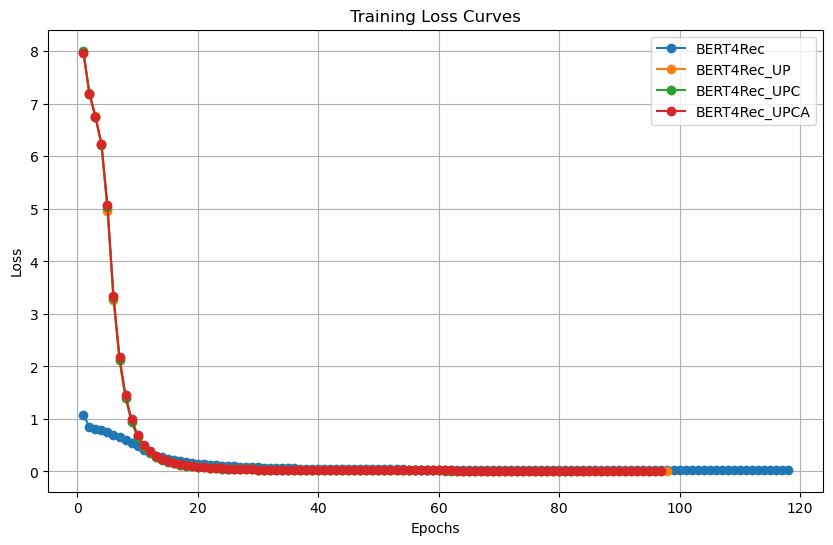

In [22]:
import matplotlib.pyplot as plt

def plot_loss_curves(losses_dict):
    """
    Plots loss curves for multiple models.
    
    Args:
        losses_dict (dict): Dictionary containing model names as keys and lists of loss values as values.
    """
    plt.figure(figsize=(10, 6))
    
    for model_name, losses in losses_dict.items():
        plt.plot(range(1, len(losses) + 1), losses, marker='o', label=model_name)
    
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training Loss Curves")
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage with sample data (replace with actual loss values from training)
losses_dict = {
    "BERT4Rec": loss_history_baseline,
    "BERT4Rec_UP": loss_history_up,
    "BERT4Rec_UPC": loss_history_upc,
    "BERT4Rec_UPCA": loss_history_upca
}

plot_loss_curves(losses_dict)

In [23]:
print(f"Genre Embedding Variance: {torch.var(model_baseline.genre_embedding.weight).item()}")

import collections

# Check how many unique movies each user cluster watches
cluster_movie_counts = collections.defaultdict(set)
for user, movies in user_movie_dict.items():
    cluster = users_dict[user]["cluster"]
    cluster_movie_counts[cluster].update(movies)

for cluster, movies in cluster_movie_counts.items():
    print(f"Cluster {cluster}: {len(movies)} unique movies")
    
import collections

genre_counts = collections.defaultdict(int)
for user, movies in user_movie_dict.items():
    user_genres = set()
    for movie in movies:
        user_genres.update(movie_dict.get(movie, []))
    genre_counts[len(user_genres)] += 1

print("Distribution of unique genres per user:")
print(sorted(genre_counts.items()))  # (Number of genres, Count of users)

Genre Embedding Variance: 0.035228412598371506
Cluster 4: 3367 unique movies
Cluster 1: 3498 unique movies
Cluster 2: 3380 unique movies
Cluster 0: 3528 unique movies
Cluster 3: 3450 unique movies
Distribution of unique genres per user:
[(5, 1), (6, 1), (7, 10), (8, 15), (9, 52), (10, 126), (11, 214), (12, 327), (13, 448), (14, 588), (15, 668), (16, 855), (17, 1306), (18, 1429)]
